In [38]:
import os
import numpy as  np
import pylab as plt
import pandas as pd
import csv
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from data_import_v2 import import_ppd, preprocess_data, crop_signal
import IPython
from IPython.display import HTML
from matplotlib.animation import FuncAnimation , PillowWriter

In [39]:
data_folder = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_EZM_GCaMP8s\Experiment\Batch2'
data_filename = 'M511-2025-11-02-104309.ppd'
mouse_id = data_filename.split('-')[0]
data = import_ppd(os.path.join(data_folder, data_filename))
# grooming_csv = pd.read_csv(r"Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\adBNST_eEPA_GCaMP8s_2nd_batch\Behavior\Binary_Behavior\M407_eEPA.csv")
# bamba_csv = pd.read_csv(r"Z:\UriMons\Fiber Photometry\adBNST_Bamba_10.24\sDarken\Processed_data\M323\binary\M323_bamba.csv")
# food_csv = pd.read_csv(r"Z:\UriMons\Fiber Photometry\adBNST_Bamba_10.24\sDarken\Processed_data\M323\binary\M323_food.csv")


In [40]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)


def fit_curve_to_signal(denoised_signal, time_seconds):
    max_sig = np.max(denoised_signal)
    inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
    bounds = ([0      , 0      , 0      , 600  , 0],
              [max_sig, max_sig, max_sig, 36000, 1])
    parms, parm_cov = curve_fit(double_exponential, time_seconds, denoised_signal, 
                                  p0=inital_params, bounds=bounds, maxfev=5000)
    expfit = double_exponential(time_seconds, *parms)
    return expfit


def shade_event(start_time, end_time, color='gray', alpha=0.5, linestyle='-', linewidth=1.0):
    # Plot vertical lines for start and end times
    plt.axvline(start_time, color=color, linestyle=linestyle, linewidth=linewidth)
    plt.axvline(end_time, color=color, linestyle=linestyle, linewidth=linewidth)
    
    # Shade the region between start and end times
    plt.fill_betweenx([-1000, 1000], start_time, end_time, color=color, alpha=alpha)
    

def find_consecutive_ones_indices(df, column_name):
    # Create a list of indices where the value is 1
    ones_indices = df.index[df[column_name] == 1].tolist()
    
    # Initialize empty list to store tuples of start and end indices
    sequences = []
    
    # Iterate over the list of indices
    start_idx = None
    for i, idx in enumerate(ones_indices):
        if i == 0 or idx != ones_indices[i-1] + 1:
            # Start of a new sequence of 1s
            start_idx = idx
        
        if i == len(ones_indices) - 1 or ones_indices[i+1] != idx + 1:
            # End of the current sequence of 1s
            sequences.append((start_idx+1, idx+1))
    
    return sequences


In [41]:
# grooming_bend_idxs = (find_consecutive_ones_indices(grooming_csv, "grooming"))
# bamba_bend_idxs = (find_consecutive_ones_indices(bamba_csv, "bamba"))
# food_bend_idxs = (find_consecutive_ones_indices(food_csv, "food"))

In [42]:
# sampling rate, starting point, ending point, if there is or isn't a third signal
data = crop_signal(data, 50, 5, 5)

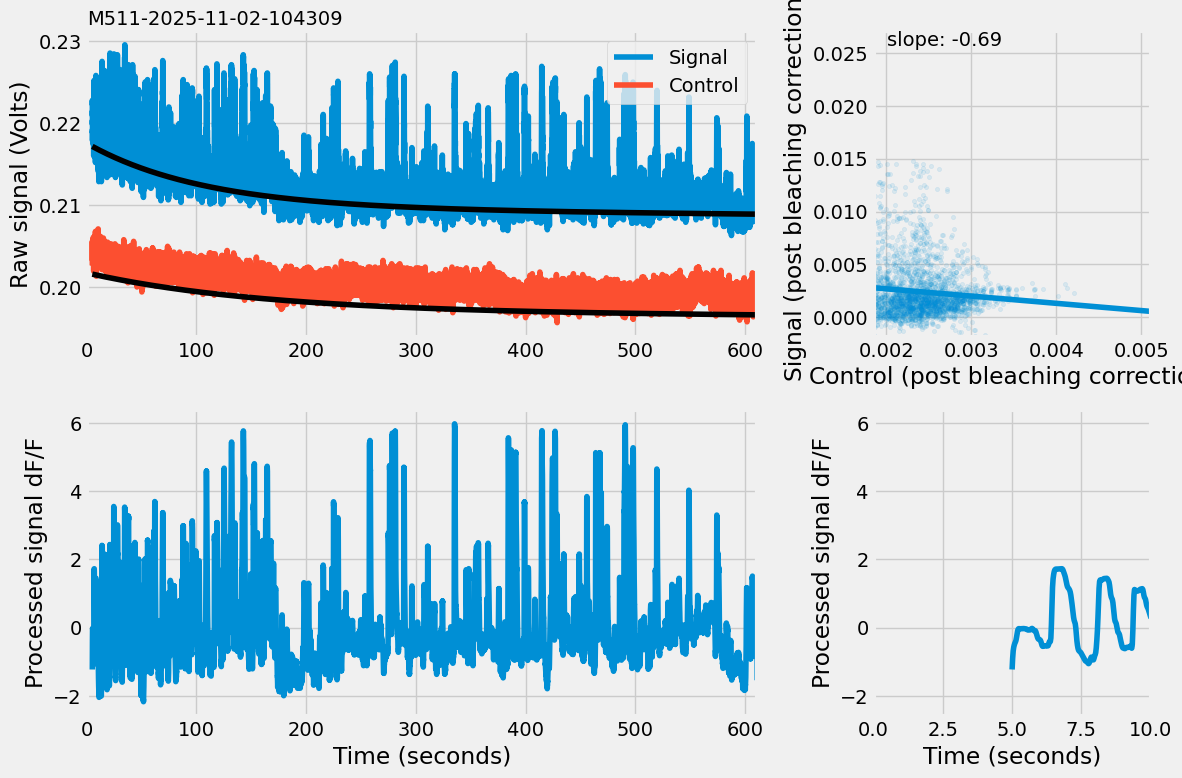

In [43]:
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.style.use('fivethirtyeight')
preprocess_data(data,plot=True,median_filter=31)  # 1st & 2nd channels 
plt.show()
if 'analog_3' in data:
    preprocess_data(data,plot=True,control = 'analog_3',median_filter=31) # 1st & 3rd channels (ISO)
    plt.show()

In [44]:
GCaMP_raw = data['analog_1']
TdTom_raw = data['analog_2'] #Main control signal
#TdTom_raw = data['analog_3']   #Secondary control signal (if exist)
time_seconds = data['time']/1000
sampling_rate = data['sampling_rate']

# digital signals
dig1 = data['digital_1']
dig2 = data['digital_2']

time_seconds = data['time']/1000
sampling_rate = data['sampling_rate']

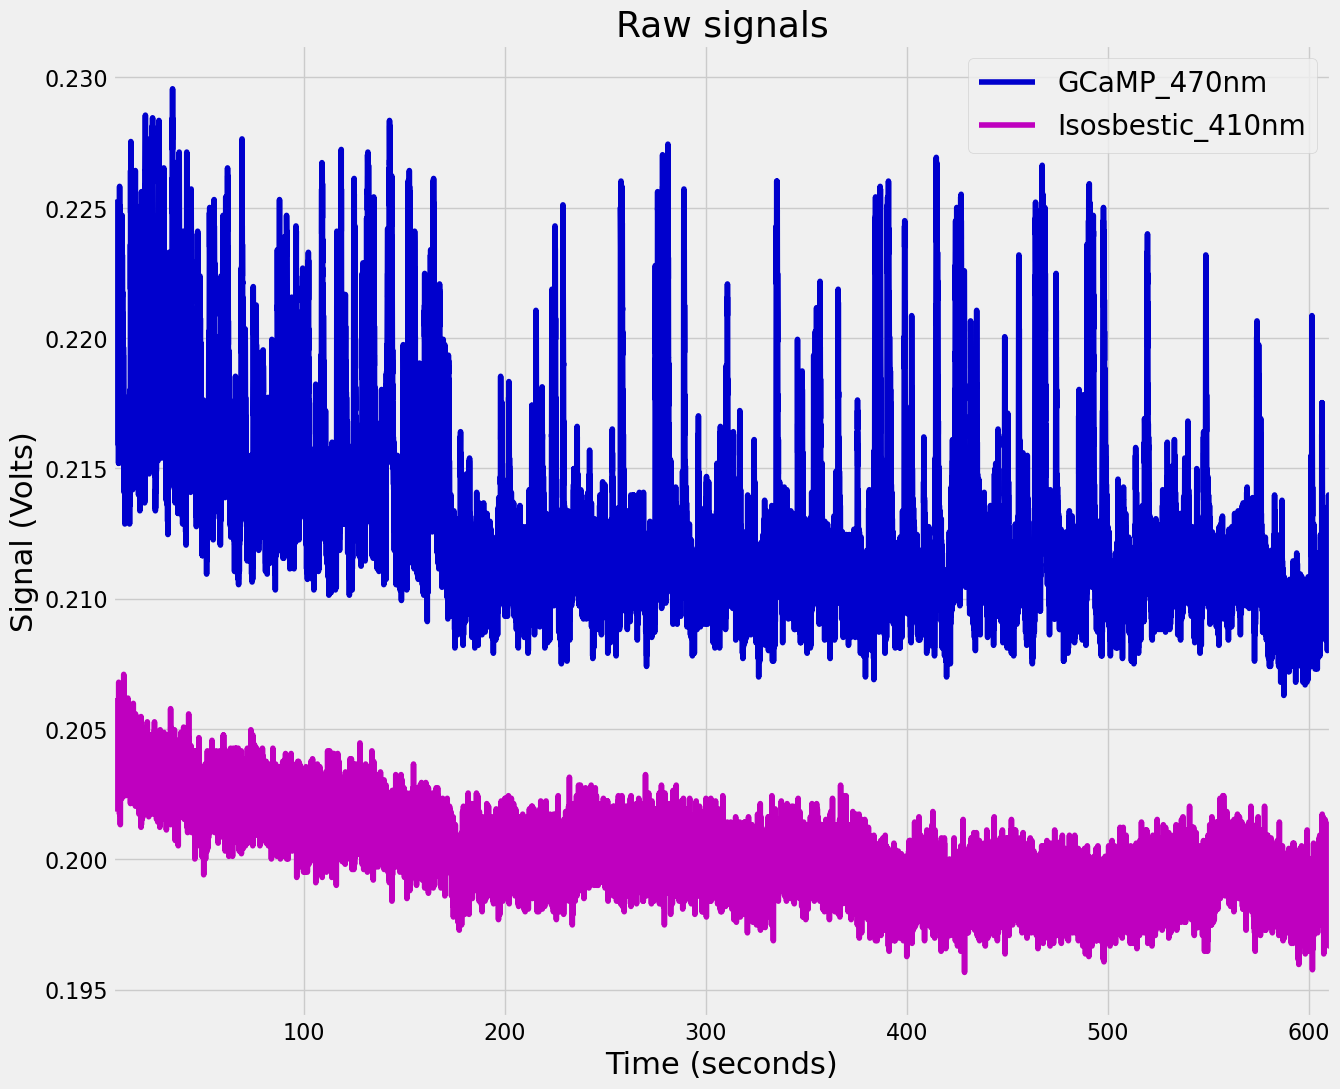

In [45]:
# Raw signals
plt.plot(time_seconds, GCaMP_raw, 'mediumblue', label='GCaMP_470nm')
plt.plot(time_seconds, TdTom_raw, 'm', label='Isosbestic_410nm')
plt.xlabel('Time (seconds)', fontsize=22)
plt.ylabel('Signal (Volts)', fontsize=22)
plt.title('Raw signals', fontsize=26)
plt.legend(fontsize=20)
plt.xticks(fontsize=16)  # Adjust fontsize as needed
plt.yticks(fontsize=16)  # Adjust fontsize as needed
plt.show()


In [46]:
# Denoising
# Median filtering to remove electrical artifact.
GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=31)
TdTom_denoised = medfilt(TdTom_raw, kernel_size=31)

# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 20, btype='low', fs=sampling_rate)
GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
TdTom_denoised = filtfilt(b,a, TdTom_denoised)

# Photobleaching correction
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
GCaMP_highpass = filtfilt(b,a, GCaMP_denoised, padtype='even')
TdTom_highpass = filtfilt(b,a, TdTom_denoised, padtype='even')

In [47]:
GCaMP_expfit = fit_curve_to_signal(GCaMP_denoised,time_seconds)
TdTom_expfit = fit_curve_to_signal(TdTom_denoised,time_seconds)

In [48]:
# Subtract the exponential fits from the signals.
GCaMP_detrended = GCaMP_denoised - GCaMP_expfit
TdTom_detrended = TdTom_denoised - TdTom_expfit

In [49]:
# Motion correction
slope, intercept, r_value, p_value, std_err = linregress(x=TdTom_detrended, y=GCaMP_detrended)

In [50]:
print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

# Subtracting estimated motion component of GCaMP to get motion corrected signal
GCaMP_est_motion = intercept + slope * TdTom_detrended
GCaMP_corrected = GCaMP_detrended - GCaMP_est_motion

Slope    : -0.683
R-squared: 0.012


In [51]:
gcamp_fps = 50  # GCaMP trace frame rate
GCaMP_dF_F = 100*GCaMP_corrected/GCaMP_expfit
# Convert GCaMP frames to time (in seconds)
time_in_seconds_gcamp = np.arange(len(GCaMP_dF_F)) / gcamp_fps

In [52]:
# print(time_in_seconds_gcamp)
# print(time_seconds)

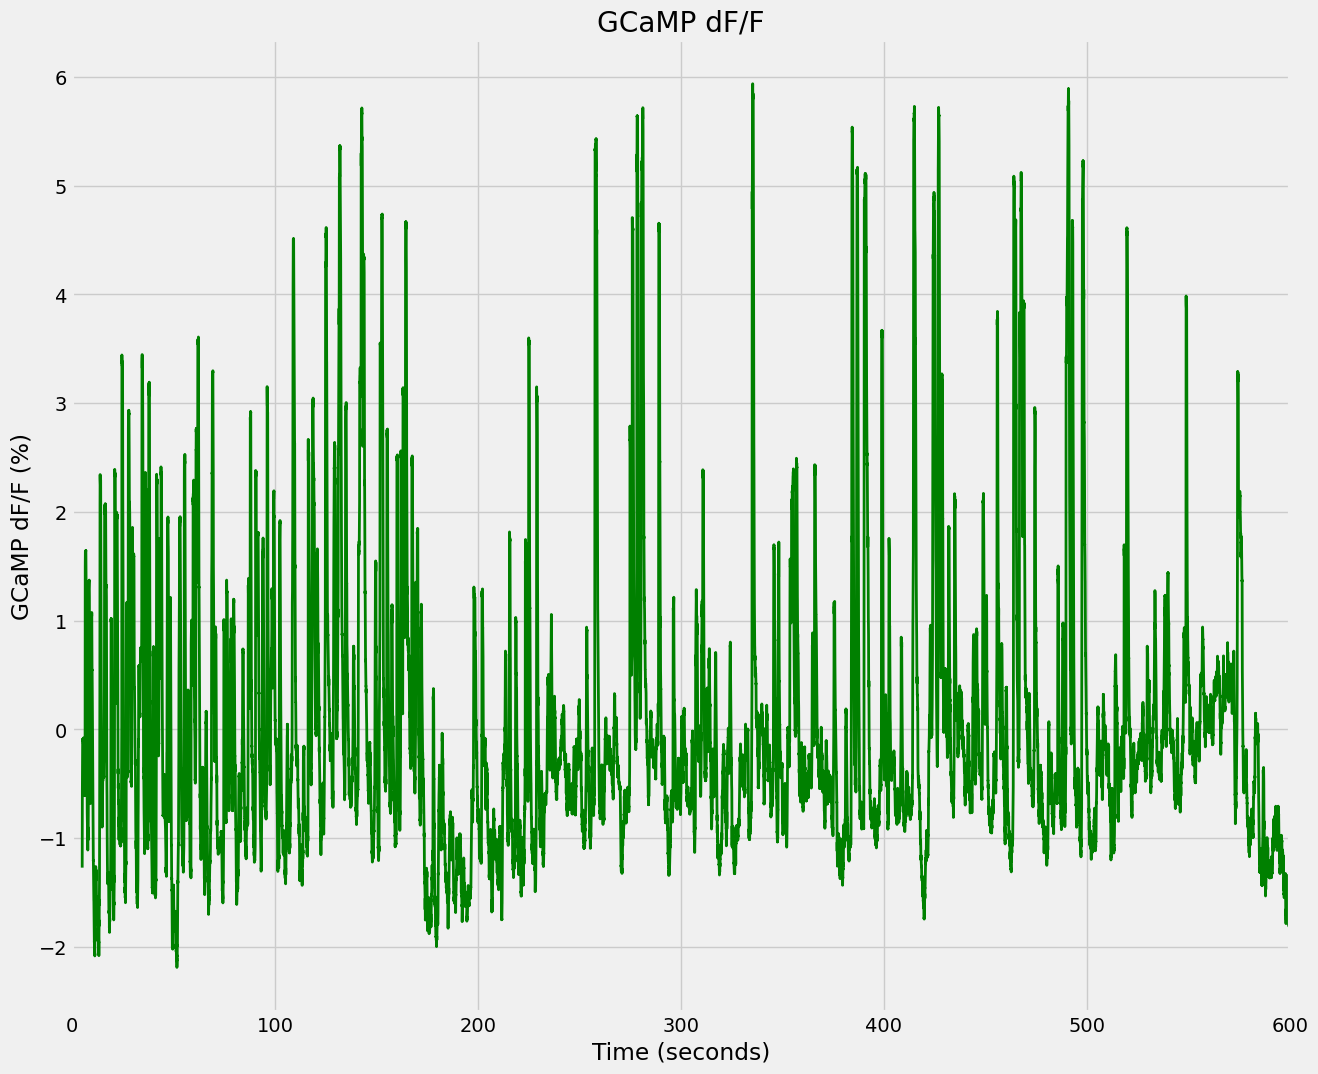

In [53]:
# Normalisation
GCaMP_dF_F = 100*GCaMP_corrected/GCaMP_expfit
plt.plot(time_seconds, GCaMP_dF_F, 'g', linewidth=2.0)
plt.xlabel('Time (seconds)')
plt.ylabel('GCaMP dF/F (%)')
plt.title('GCaMP dF/F')
plt.xlim(00, 600);
#plt.grid(True)
plt.show()

In [54]:
# # Normalisation
# GCaMP_dF_F = 100*GCaMP_corrected/GCaMP_expfit
# plt.plot(time_seconds, GCaMP_dF_F, 'g', linewidth=2.0)

# def Linear_reg(X):
#     return 0.03342285848*X - 0.9540002344

# def Linear_reg_frame2time(X:int, first_choosen_led_frame: int, second_choosen_led_frame:int):
#     return Linear_reg(first_choosen_led_frame)+(X-first_choosen_led_frame)*(Linear_reg(second_choosen_led_frame)-Linear_reg(first_choosen_led_frame))/(second_choosen_led_frame-first_choosen_led_frame)

# def frame2time(frame):
#     return frame/30

# puls_time = data['pulse_times_2']

# # #insert frames with led light on
# # first_choosen_led_frame = 5696
# # second_choosen_led_frame = 11304

# #insert frames in which the walls went down and up 
# Walls_down_frame_start = 53990
# Walls_down_frame_end = 54032
# Walls_up_frame_start = 53990
# Walls_up_frame_end = 54032
# # print (puls_time)

# for start, end in grooming_bend_idxs:
#     shade_event(frame2time(start), frame2time(end), 'b', 0.3, '-', 0)
# shade_event(frame2time(Walls_down_frame_start), frame2time(Walls_down_frame_end), '#FFBD00', 0.5, '-', 0)
# shade_event(frame2time(Walls_up_frame_start), frame2time(Walls_up_frame_end), '#FFBD00', 0.5, '-', 0)

# # for start, end in bamba_bend_idxs:
# #     shade_event(frame2time(start), frame2time(end), 'y', 0.5, '-', 0)
# # shade_event(frame2time(Walls_down_frame_start), frame2time(Walls_down_frame_end), '#FFBD00', 0.5, '-', 0)
# # shade_event(frame2time(Walls_up_frame_start), frame2time(Walls_up_frame_end), '#FFBD00', 0.5, '-', 0)

# # for start, end in food_bend_idxs:
# #     shade_event(frame2time(start), frame2time(end), 'brown', 0.5, '-', 0)
# # shade_event(frame2time(Walls_down_frame_start), frame2time(Walls_down_frame_end), '#FFBD00', 0.5, '-', 0)
# # shade_event(frame2time(Walls_up_frame_start), frame2time(Walls_up_frame_end), '#FFBD00', 0.5, '-', 0)

# # for start, end in rearing_bend_idxs:
# #     shade_event(frame2time2(start, first_choosen_led_frame, second_choosen_led_frame), frame2time2(end, first_choosen_led_frame, second_choosen_led_frame), 'r', 0.3, '-', 0)
# # shade_event(frame2time2(Walls_down_frame_start, first_choosen_led_frame, second_choosen_led_frame), frame2time2(Walls_down_frame_end, first_choosen_led_frame, second_choosen_led_frame), '#FFBD00', 0.5, '-', 0)
# # shade_event(frame2time2(Walls_up_frame_start, first_choosen_led_frame, second_choosen_led_frame), frame2time2(Walls_up_frame_end, first_choosen_led_frame, second_choosen_led_frame), '#FFBD00', 0.5, '-', 0)

# plt.rcParams['figure.figsize'] = [14, 6] # Make default figure size larger.

# plt.xlabel('Time (seconds)', fontsize=26)
# plt.ylabel('GCaMP dF/F (%)', fontsize=26)
# plt.title('GCaMP dF/F', fontsize=30)
# plt.xlim(00, 3000)
# plt.ylim(-2, 8)
# plt.xticks(fontsize=22)  # Adjust fontsize as needed
# plt.yticks(fontsize=22)  # Adjust fontsize as needed
# #plt.grid(True)
# plt.show()

In [55]:
# # Specify the directory for saving the files
# output_dir = r"Z:\UriMons\Fiber Photometry\10.24_adBNST_Bamba\sDarken"
# res_path = os.path.join(output_dir, f"{mouse_id}_res.npy")


# # Create the directory if it does not exist
# os.makedirs(output_dir, exist_ok=True)

# # Define filenames for each array
# #file_gc = os.path.join(output_dir, "M264_GCaMP_raw.npy")
# #file_td = os.path.join(output_dir, "M264_TdTom_raw.npy")
# #file_df = os.path.join(output_dir, "M264_GCaMP_dF_F.npy")


# # Save each array to its respective file
# # np.save(file_gc, GCaMP_raw)
# # np.save(file_td, TdTom_raw)
# # np.save(file_df, GCaMP_dF_F)


# res = {"GCaMP_raw" : GCaMP_raw, "TdTom_raw":TdTom_raw,"GCaMP_dF_F":GCaMP_dF_F, "time": time_seconds}
# np.save(res_path, res)
# print(f"Arrays saved to {output_dir}")
